## GEOCODING: API call + spatial join, or merge on names?

In [6]:
import pandas as pd
import geopandas as gpd # pip install geopandas
import json
from pandas import json_normalize
from ast import literal_eval
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import json
import requests
from requests.structures import CaseInsensitiveDict

import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import mapclassify # pip install mapclassify
from matplotlib.colors import rgb2hex
from matplotlib.colors import ListedColormap
plt.style.use('seaborn')


#conda install -c conda-forge cartopy
#then
#!pip install cartopy
#then
#pip install geoviews
# https://github.com/SciTools/cartopy/issues/1940#issuecomment-1303377066

#GPEtags = pd.read_csv("20species_GPEtags.csv", sep = ";")
#pd.set_option('display.max_rows', 500)

/tmp/ipykernel_44/2767306344.py:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
# Read in shapefile with Point data
gdf = gpd.read_file("shapefiles/Geo_tags_test.shp")
# Rename columns for clarity 
gdf = gdf.rename(columns = {'Country_co' : 'txt_mentions', 'scientific' : 'sci_name'})

world = gpd.read_file("shapefiles/World_Countries__Generalized_.shp")
# Read in the dataframe with gpe info 
gpe = pd.read_csv("csv/speciesinfo_gpetags.csv", sep = ";")

#### Necessary only for retrieving Point data

In [63]:
# For retrieveing the Point data from the country names in the dataframe
# Create an empty list for storing the json responses
locs = []

# Loop through the country names in the dataframe 
for text in gpe['Countries'].unique():
    # Limiting to 1 result returns the most likely possibility, the country location 
    url = "https://api.geoapify.com/v1/geocode/search?text=" + text + "&limit=1&type=country&apiKey=eb01bd79a67243d6856bfbe209afe526"
    
    headers = CaseInsensitiveDict()
    headers["Accept"] = "application/json"

    resp = requests.get(url, headers=headers)
    
    try:
        locs.append(resp.json()['features'][0]['properties'])
    except IndexError: 
        url = "https://api.geoapify.com/v1/geocode/search?text=" + text + "&limit=1&apiKey=eb01bd79a67243d6856bfbe209afe526"
    
        headers = CaseInsensitiveDict()
        headers["Accept"] = "application/json"

        resp = requests.get(url, headers=headers)
        locs.append(resp.json()['features'][0]['properties'])


In [ ]:
test = []
# Loop over the list with json responses of country name and geodata
for n in range(len(locs)):
    # Store the geometry and name of each response into a dictionary
    geom = {'geometry' : (locs[n]['lon'], locs[n]['lat'])}
    name = {'name' : locs[n]['formatted']}
    
    # loop over both dictionaries simultaneously and store the result into a tuple
    # to then append to the empty list that was previously defined 
    for g, n in zip(geom, name):
        t = (name[n], geom[g])
        test.append(t)
        
# Create a dataframe from the list       
geom = pd.DataFrame(test, columns =['Countries', 'geometry'])

In [ ]:
from shapely.geometry import Point
# apply Shapely Point to turn tuples into coordinates
geom['Coordinates'] = geom['geometry'].apply(lambda x: Point(x))
# Create a geodataframe from the pandas dataframe
gdf = gpd.GeoDataFrame(geom, geometry="Coordinates")
gdf = gdf.set_crs('epsg:4326')

In [ ]:
# Spatial join between the point data and ready polygon data of countries 
globeshps = world.sjoin(gdf, how="left", predicate='contains').reset_index(drop = True).drop(columns = "geometry_right")

In [45]:
geospecies.loc[geospecies['geometry'].isnull()]['Countries_x'].unique()

array(['palau', 'bahamas', 'hong kong', 'macao', 'dominica', 'aruba',
       'puerto rico', 'lebanon', 'montenegro', 'kosovo', 'guam', 'malta',
       'ivory coast', 'jordan', 'gambia', 'swaziland', 'guernsey',
       'macedonia'], dtype=object)

#### Processing and Joining 

In [175]:
# Finding the top country for each species (according to text mentions of that country in each species' article) and keeping only those rows
topspecies_country = gpe.loc[gpe.groupby("scientific_name")['mentions_country'].idxmax()].reset_index(drop = True)

# Counting how many species each country is listed as the top one
topcountries = topspecies_country.groupby(topspecies_country["Countries"].tolist(),as_index=False)\
            .size().sort_values(by="size", ascending = False).reset_index(drop = True)

# Rename columns more intuitvely
topcountries = topcountries.rename(columns = {'index' : 'Country', 'size' : 'species_count'})
# Manual change of country name to match to shapefiles
topcountries['Country'] = topcountries['Country'].str.replace("russia", "russian federation")

In [176]:
# merge the dataframes on their names 
topstateshp = pd.merge(topcountries, world, left_on=topcountries["Country"], right_on=world["COUNTRY"].str.lower(),\
                       how="right").drop(columns = "key_0")
# re-establish that it is a geodataframe
topstates_shp = gpd.GeoDataFrame(topstateshp, geometry='geometry')

In [5]:
## ONLY FOR SPATIAL JOIN
world_gpe = world.sjoin(gdf, how="inner", predicate='contains').reset_index(drop = True)

df = (world_gpe.groupby(['COUNTRY','FID'])
      .agg({'sci_name': lambda x: x.tolist(),'txt_mentions':'sum','article_co':'sum'})
      .rename({'txt_mentions' : 'Sum_txt_mentns','article_co' : 'Sum_articles'},axis=1)
      .reset_index())

df['species_num'] = df['sci_name'].str.len()

sample_map = df.merge(world, on = 'FID', how = 'left')
geosample = gpd.GeoDataFrame(sample_map, geometry='geometry')

Text(0.5, 1.0, "Most frequently mentioned countries of each species' news articles")

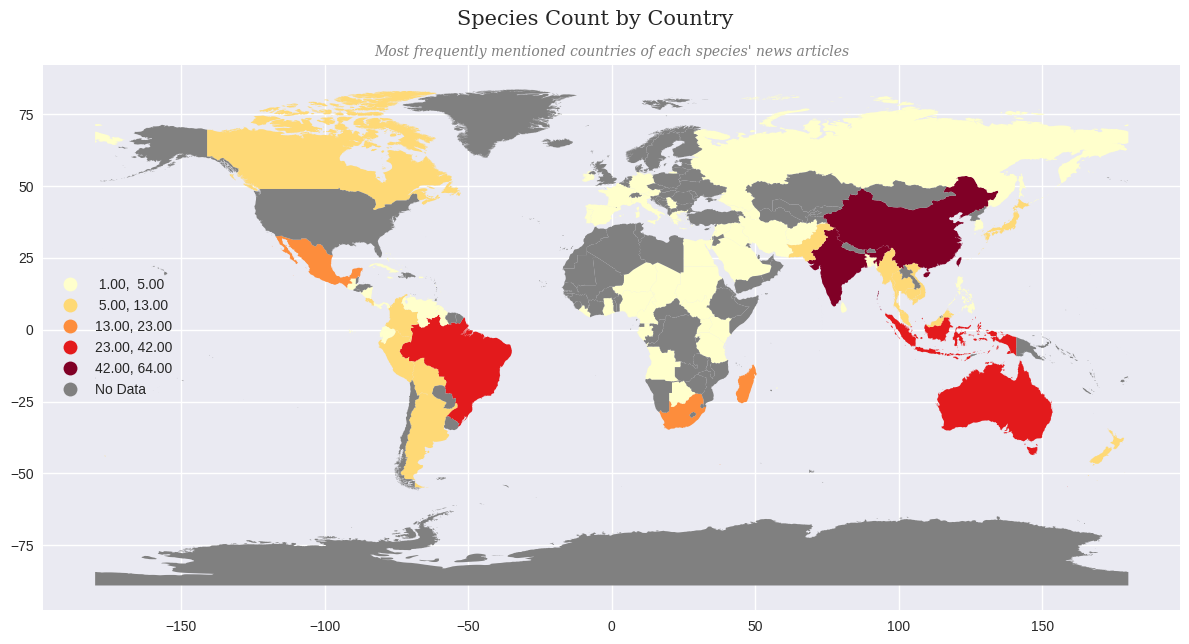

In [177]:
# Sample map
#topstates_shp.plot(topstates_shp['species_count'], legend = True, figsize = (12,5), )
fig, ax = plt.subplots(figsize=(12, 10))

cmap = plt.cm.get_cmap('YlOrRd', 5)
missing_kwds = dict(color='grey', label='No Data')

topstates_shp.plot(column='species_count', scheme='NaturalBreaks', k= 5, cmap = cmap,
         legend=True, legend_kwds=dict(loc='center left'),
         missing_kwds=missing_kwds, ax=ax)

# Add suptitle above the title
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Species Count by Country", fontsize=15, family = 'Serif')
plt.subplots_adjust(top=1.26)
ax.set_title("Most frequently mentioned countries of each species' news articles", \
             fontsize = 10, color="grey", style='italic', family = 'Serif')

#plt.savefig('figures/temp.png')

In [3]:
# Similar visualziation but this time aggregating all country mentions in the articles 
allmentions = gpe.groupby("Countries")['mentions_country'].sum().sort_values(ascending = False).reset_index()
# Naming conventions different, manual change
allmentions['Countries'] = allmentions['Countries'].str.replace("russia", "russian federation")

# Merge on country name after temporarily lowering the case of the names in the world gdf
mentionsgdf = pd.merge(allmentions, world, left_on=allmentions["Countries"], right_on=world["COUNTRY"]\
                       .str.lower(), how="right").drop(columns = "key_0")

# Redefine as a geodataframe
mentionsgdf = gpd.GeoDataFrame(mentionsgdf, geometry='geometry')

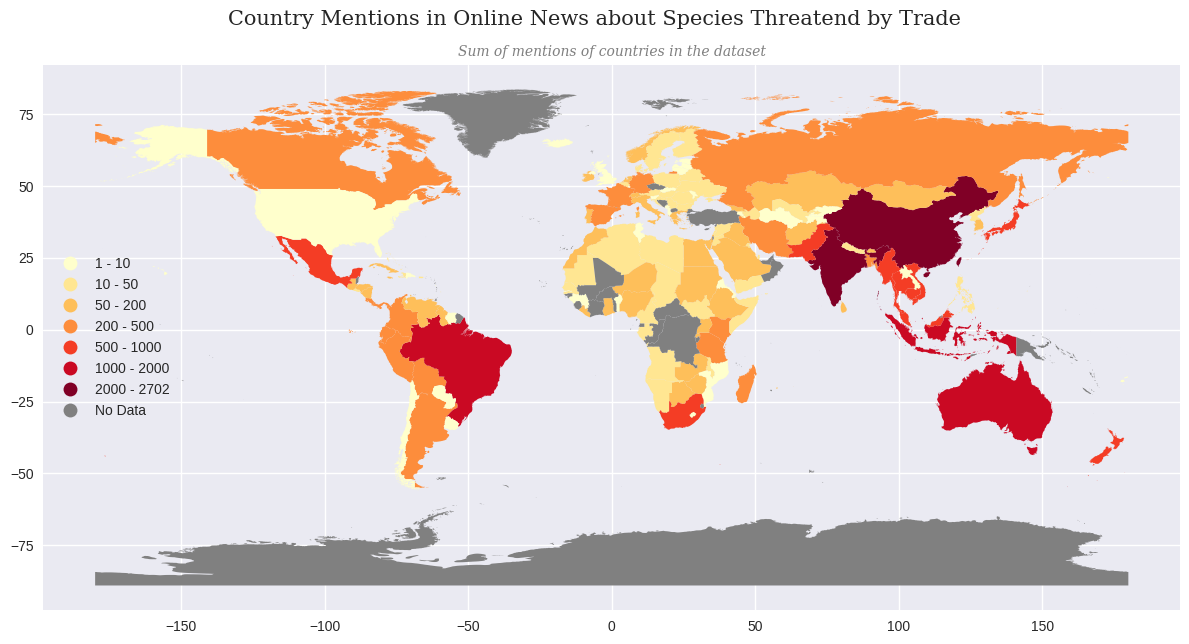

In [33]:
fig, ax = plt.subplots(figsize=(12, 10))

# Define color map and how many bins needed
cmap = plt.cm.get_cmap('YlOrRd', 7)
# Any countries with NaN values will be colored grey
missing_kwds = dict(color='grey', label='No Data')

# Classification scheme options: EqualInterval, Quantiles, NaturalBreaks, UserDefined etc.
mentionsgdf.plot(column='mentions_country', 
                 scheme='UserDefined', 
                 classification_kwds = {'bins':[10, 50, 200, 500, 1000, 2000, 2702]}, 
                 cmap = cmap, 
                 legend=True, 
                 legend_kwds=({"loc":'center left'}), 
                 missing_kwds=missing_kwds, 
                 ax=ax)

# Define the bounds of the classification scheme
upper_bounds = mapclassify.UserDefined(mentionsgdf.mentions_country, 
                                       bins=[10, 50, 200, 500, 1000, 2000, 2702]).bins

bounds = []
for index, upper_bound in enumerate(upper_bounds):
    if index == 0:
        lower_bound = mentionsgdf.mentions_country.min()
    else:
        lower_bound = upper_bounds[index-1]

    bound = f'{lower_bound:.0f} - {upper_bound:.0f}'
    bounds.append(bound)

    
# get all the legend labels
legend_labels = ax.get_legend().get_texts()

# replace the legend labels
for bound, legend_label in zip(bounds, legend_labels):
    legend_label.set_text(bound)
    

# Add suptitle above the title
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Country Mentions in Online News about Species Threatend by Trade", fontsize=15, family = 'Serif')
plt.subplots_adjust(top=1.26)
ax.set_title("Sum of mentions of countries in the dataset", 
             fontsize = 10, color="grey", style='italic', family = 'Serif')

plt.savefig('figures/countrymentions.png')

### Old Maps

In [29]:
from bokeh.palettes import Category20
from bokeh.plotting import figure, output_file, show
from bokeh.models import ColumnDataSource
# pip install bokeh

#p = figure(title="What countries are mentioned most often in articles about each species",
          #toolbar_location=None, width=600, height=400)

#source = ColumnDataSource(data=world_gpe)

#for df, color in zip([world_gpe], Category20):
    #print(len(df['sci_name'].unique()))
    
    #p.plot(df['geometry'], color=color, alpha=0.8, legend_label=df['sci_name'].unique())
    
def getPolyCoords(row, geom, coord_type):
    if coord_type == 'x':
        return list(row[geom].exterior.coords.xy[0])
    elif coord_type == 'y':
        return list(row[geom].exterior.coords.xy[1])
    
gdf = geosample.copy()    
gdf['x'] = gdf.apply(getPolyCoords, geom = 'geometry', coord_type = 'x', axis = 1)
gdf['y'] = gdf.apply(getPolyCoords, geom = 'geometry', coord_type = 'y', axis = 1)
p_df = gdf.drop('geometry', axis = 1).copy()
p = figure(title = "A map from Shapefile", plot_width = 800)
p.patches('x', 'y', source = ColumnDataSource(p_df), line_color = "white", line_width = 0.5)
show(p)

AttributeError: 'MultiPolygon' object has no attribute 'exterior'

In [11]:
# Create a world map to show distributions of users 
# NOT A GOOD VISUALIZATION need to demonstrate size according to species count value
import folium
from folium.plugins import MarkerCluster
from folium.plugins import HeatMap
#empty map
world_map= folium.Map(tiles="cartodbpositron")
#m = MarkerCluster().add_to(world_map)
features = {}
for row in pd.unique(gdf["scientific_name"]):
    features[row] = folium.FeatureGroup(name=row)
#for each coordinate, create circlemarker of user percent
for i in range(len(gdf)):
    lat = gdf.iloc[i]['Coordinates'].x
    long = gdf.iloc[i]['Coordinates'].y
    radius=float(gdf.iloc[i]['Country_count'])*4000
    popup_text = """Country : {}<br>
                Species : {}<br>"""
    popup_text = popup_text.format(gdf.iloc[i]['Countries'],
                                gdf.iloc[i]['scientific_name'])
    folium.Circle(location = [lat, long], radius = radius, popup= popup_text, fill =True).add_to(world_map)
#show the map
world_map

In [44]:
# Drop the tuples columnn, rename the shapely column, set the crs and reset the geometry column
gdf.drop(columns = 'geometry', inplace = True)

In [45]:
import fiona 
gdf.to_file('Geo_tags_test.shp')

/tmp/ipykernel_44/1482716497.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file('Geo_tags_test.shp')
